In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import mplcyberpunk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

plt.style.use('cyberpunk')

## <b>Load Dataset</b>

In [121]:
data = pd.read_csv("../cleaned/CampaignPerformance.csv")

## <b>Cleaning & Preprocessing</b> 
`has been done earlier`

## <b>Feature Engineering</b>

In [122]:
data['dates'] = pd.to_datetime(data['dates'])
data['cost_per_lead'] = data['total_spent']/(data['leads']+1)
data['roas'] = data['leads']/(data['total_spent']+1)

In [123]:
data.describe()

,total_spent,impressions,clicks,click_through_rate,leads,cost_per_lead,roas
count,27948.000000,27948.000000,27948.000000,27948.000000,27948.000000,27948.000000,27948.000000
mean,559.133872,2386.341241,18.719801,1.351248,1.151043,202.059366,0.002268
std,1473.100298,8049.391961,79.100485,5.555901,3.988680,434.538552,0.015632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.530000,13.000000,0.000000,0.000000,0.000000,5.450000,0.000000
50%,53.600000,108.000000,1.000000,0.332196,0.000000,46.535000,0.000000
75%,428.072500,1269.250000,9.000000,0.847458,1.000000,204.748125,0.000848
max,27125.360000,196585.000000,3361.000000,200.000000,153.000000,10365.930000,1.000000


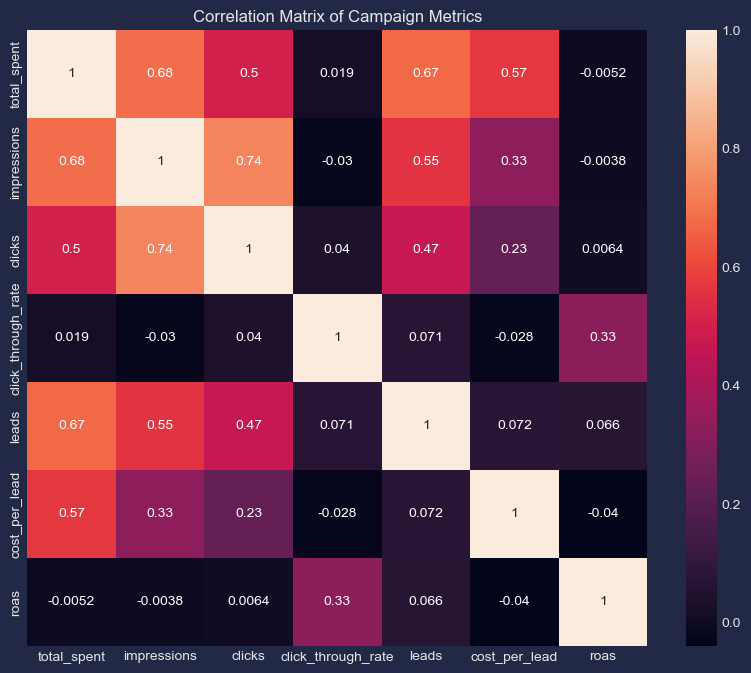

In [124]:
correlation_matrix = data[['total_spent', 'impressions', 'clicks', 'click_through_rate', 'leads', 'cost_per_lead', 'roas']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Campaign Metrics')
plt.show()

In [125]:
data['month'] = data['dates'].dt.month
data['day_of_week'] = data['dates'].dt.dayofweek

## <b>Feature Transformation</b>

In [126]:
from scipy.stats import skew
import scipy

In [127]:
numerical_features = data.select_dtypes(include=['number'])
skewness_values = numerical_features.apply(lambda x: scipy.stats.skew(x))
skewness_values

total_spent            6.166763
impressions            9.677399
clicks                15.238373
click_through_rate    15.626920
leads                 10.593737
cost_per_lead          5.758055
roas                  32.318290
month                  0.798910
day_of_week           -0.052535
dtype: float64

In [128]:
def normalize_skewed_features(df, threshold=0.5):
    
    numerical_features = df.select_dtypes(include=['number'])
    skewness_values = numerical_features.apply(lambda x: skew(x))
    skewed_features = skewness_values[abs(skewness_values) > threshold].index
    for feature in skewed_features:
        df[feature] = np.log1p(df[feature])
    
    return df

In [129]:
data = normalize_skewed_features(data)

## <b>Scaling & Encoding</b>

In [130]:
categorical_cols = data.select_dtypes(include=['object', 'category', 'bool']).columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [131]:
df_encoded = data_encoded.copy()

In [132]:
features = [col for col in data_encoded.columns if col not in ['dates', 'total_spent', 'leads', 'cost_per_lead', 'roas']]
X = data_encoded[features]
y = data_encoded['roas']

In [133]:
X.columns

Index(['impressions', 'clicks', 'click_through_rate', 'month', 'day_of_week',
       'campaign_name_CBO - USP Masterclass Cold [ 15th Dec ] - More Volume - No Logic - India Â– New Link',
       'campaign_name_CBO - USP Masterclass Cold [ 23rd Nov ] - Higher Intent - No Logic new-  India',
       'campaign_name_CBO - USP Masterclass Cold [ 23rd Nov ] - More volume - With Logic',
       'campaign_name_USP Masterclass Cold [ 14th Dec ] - Link Click Ad',
       'campaign_name_USP Masterclass Cold [ 23rd Nov ] - More volume - With Logic - India',
       ...
       'adset_name_Related To Study In US_India',
       'adset_name_Related To Study In US_South-states',
       'adset_name_Study Abroad',
       'adset_name_Top 4 states focusing on Uni Ad Set_060324',
       'adset_name_USP-2_AP_TS_050424',
       'adset_name_USP-2_Data_Job-title_India_exclude_KATNTSAP',
       'adset_name_USP-2_Data_Job-title_KATNTSAP',
       'adset_name_USP-2_KA_TN_050424', 'adset_name_YT_Channels_URL_targeting',


In [134]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## <b>Modelling</b>

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [136]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [137]:
rf = RandomForestRegressor(random_state=42)

## <b>Hyperparameter Tuning</b>

In [138]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    }
    rf = RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)

    X_sample, y_sample = X_train[:1000], y_train[:1000]
    
    return -np.mean(cross_val_score(rf, X_sample, y_sample, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, timeout=300)
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

print("Best parameters:", best_params)
print("Best score:", -study.best_value)

[I 2024-08-20 17:17:49,104] A new study created in memory with name: no-name-b0a1285c-a47d-4f64-81d0-8a05393e3cc7
[I 2024-08-20 17:17:54,517] Trial 0 finished with value: 0.003232371404747143 and parameters: {'n_estimators': 191, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 0 with value: 0.003232371404747143.
[I 2024-08-20 17:17:57,250] Trial 1 finished with value: 0.003936661095049396 and parameters: {'n_estimators': 106, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.003232371404747143.
[I 2024-08-20 17:18:00,164] Trial 2 finished with value: 0.0038222798888587206 and parameters: {'n_estimators': 187, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.003232371404747143.
[I 2024-08-20 17:18:00,852] Trial 3 finished with value: 0.00391068118319974 and parameters: {'n_estimators': 135, 'max_d

Best parameters: {'n_estimators': 168, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto'}
Best score: -0.003042068291124781


## <b>Feature Importance</b>

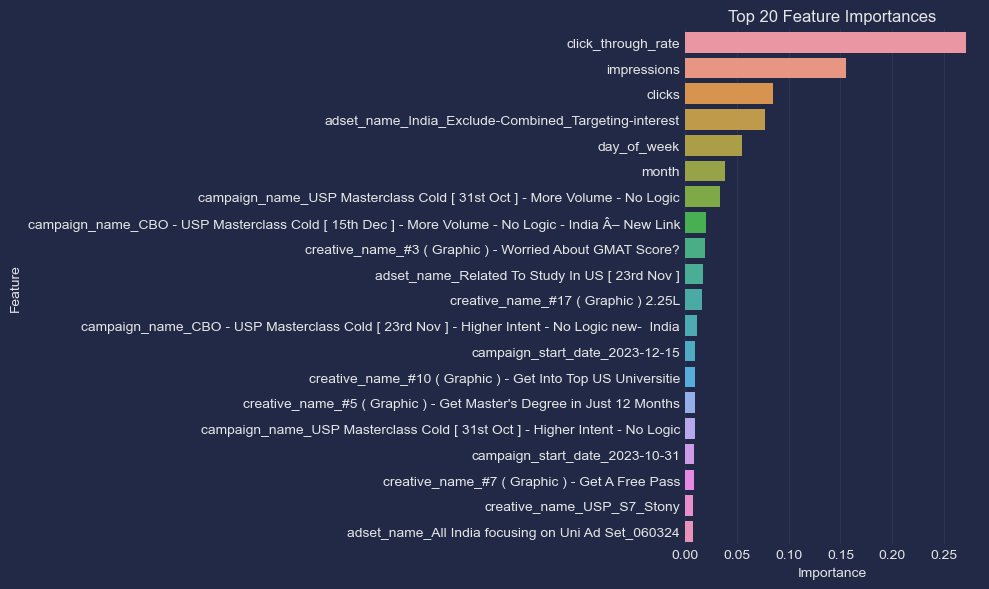

In [139]:
importances = best_model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X.columns), reverse=True), columns=['Importance', 'Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

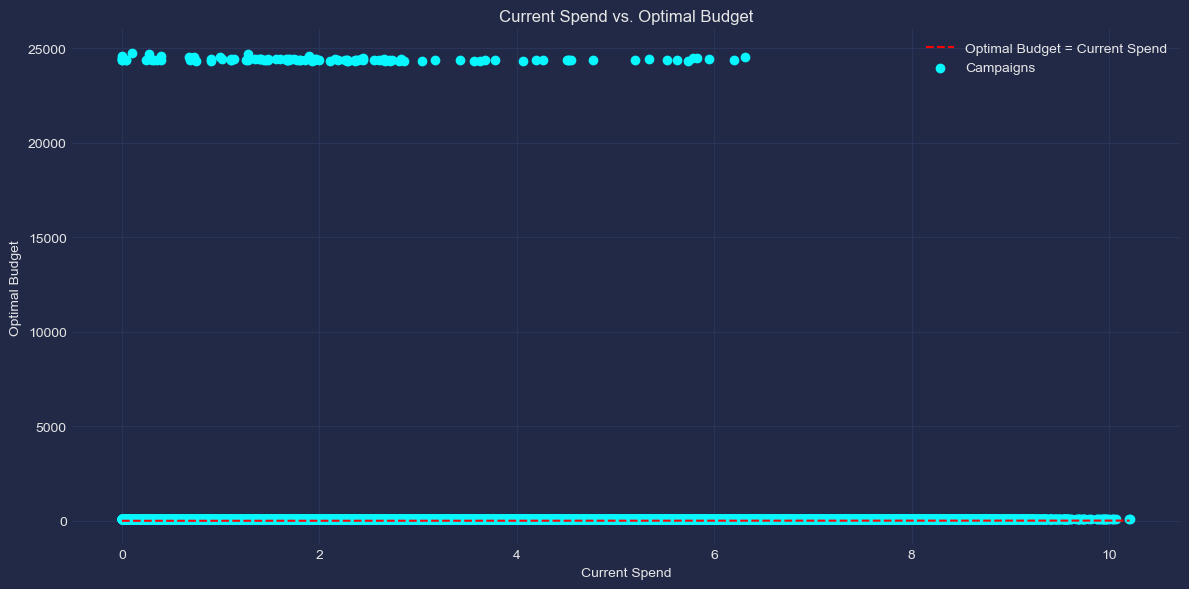

Top 10 Campaigns by Optimal Budget:
campaign_name
USP Study Abroad_Generic_240224                                                           774402.121911
CBO - USP Masterclass Cold [ 23rd Nov ] - Higher Intent - No Logic new-  India            493579.235488
USP Masterclass Cold [ 31st Oct ] - Higher Intent - No Logic                              452472.756010
CBO - USP Masterclass Cold [ 15th Dec ] - More Volume - No Logic - India Â– New Link      420651.280318
USP Masterclass Cold [ 31st Oct ] - More Volume - No Logic                                395519.375413
USP_2_Lead-gen-1_220124                                                                   346115.718828
USP_MS + Coop Campaign_240224                                                             212800.144978
US_Pathway_2_Lead_gen_1_091123                                                            188066.749471
CBO - USP Masterclass Cold [ 15th Dec ] - Higher Intent - No Logic - India Â– new link    172862.904944
USP_Program_Le

In [141]:
def optimize_budget(df, model, total_budget, min_budget_per_campaign=100):
    
    X_pred = df[features]
    X_pred_scaled = scaler.transform(X_pred)
    
    predicted_roas = model.predict(X_pred_scaled)
    
    total_roas = predicted_roas.sum()
    optimal_budgets = (predicted_roas / total_roas) * total_budget
    
    while np.any(optimal_budgets < min_budget_per_campaign):
        mask = optimal_budgets < min_budget_per_campaign
        excess = np.sum(optimal_budgets[mask] - min_budget_per_campaign)
        optimal_budgets[mask] = min_budget_per_campaign
        optimal_budgets[~mask] -= excess / np.sum(~mask)
    
    return optimal_budgets

total_budget = data['total_spent'].sum()  # Use the same total budget as before
optimal_budgets = optimize_budget(df_encoded, best_model, total_budget)

plt.figure(figsize=(12, 6))
plt.scatter(data['total_spent'], data['optimal_budget'], label='Campaigns')
plt.plot([0, data['total_spent'].max()], [0, data['total_spent'].max()], 'r--', label='Optimal Budget = Current Spend')
plt.xlabel('Current Spend')
plt.ylabel('Optimal Budget')
plt.title('Current Spend vs. Optimal Budget')
plt.legend()
plt.tight_layout()
plt.show()


top_campaigns = data.groupby('campaign_name')['optimal_budget'].sum().sort_values(ascending=False).head(10)
print("Top 10 Campaigns by Optimal Budget:")
print(top_campaigns)